In this project, we are  going to focus on business owners in the United States. We will start by examining some demographic characteristics of the group, such as age, income category, and debt vs home value. Then we will select high-variance features, and create a clustering model to divide small business owners into subgroups. Finally, we will create some visualizations to highlight the differences between these subgroups.

In [23]:
# Import libraries here
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats.mstats import trimmed_var
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [24]:
df = pd.read_csv("data/SCFP2019.csv")
print("df shape:", df.shape)
df.head()

df shape: (28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


In [25]:
df.dtypes

YY1               int64
Y1                int64
WGT             float64
HHSEX             int64
AGE               int64
                 ...   
NWPCTLECAT        int64
INCPCTLECAT       int64
NINCPCTLECAT      int64
INCQRTCAT         int64
NINCQRTCAT        int64
Length: 351, dtype: object

In [26]:
pct_biz_owners = df[df.HBUS == 1].shape[0] / len(df)
print("Proportion of business owners in df:", pct_biz_owners)

Proportion of business owners in df: 0.2740176562229531


Now we will check how the distribution of income is different between business owners and non-business owners.

In [27]:
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100"
}

df_inccat = (
    df["INCCAT"]
    .replace(inccat_dict)
    .groupby(df["HBUS"])
    .value_counts(normalize=True)
    .rename("frequency")
    .reset_index()
)

df_inccat.head(10)

,HBUS,INCCAT,frequency
0,0,0-20,0.210348
1,0,21-39.9,0.198140
2,0,40-59.9,0.189080
3,0,60-79.9,0.186600
4,0,90-100,0.117167
5,0,80-89.9,0.098665
6,1,90-100,0.629438
7,1,60-79.9,0.119015
8,1,80-89.9,0.097410
9,1,40-59.9,0.071510


Text(0, 0.5, 'Frequency (%)')

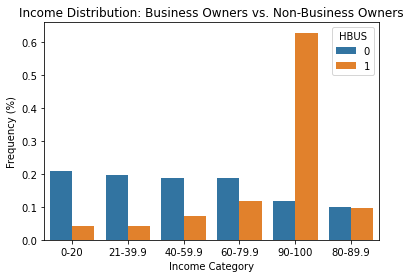

In [28]:
# Create bar chart of `df_inccat`
chart = sns.barplot(
    x = "INCCAT",
    y = "frequency",
    hue = "HBUS",
    data = df_inccat
)

chart.set_title("Income Distribution: Business Owners vs. Non-Business Owners")
chart.set_xlabel("Income Category")
chart.set_ylabel("Frequency (%)")

From the barplot we can see, business owners mostly reside in high income categories whereas non-business owners are spread out between low to high income categories.

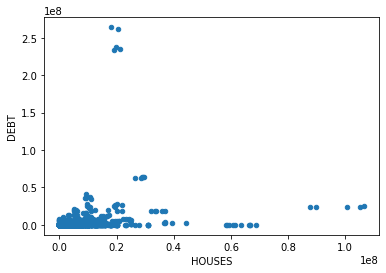

In [29]:
# Plot "HOUSES" vs "DEBT" with hue=label
df.plot.scatter(x="HOUSES", y = "DEBT");

In [30]:
mask = (df["HBUS"] == 1) & (df["INCOME"] < 5e5)
df_small_biz = df[mask]
print("df_small_biz shape:", df_small_biz.shape)
df_small_biz.head()

df_small_biz shape: (4364, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
80,17,171,7802.265717,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
81,17,172,8247.536301,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
82,17,173,8169.562719,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
83,17,174,8087.704517,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
84,17,175,8276.510048,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4


Text(0.5, 1.0, 'Small Business Owners: Age Distribution')

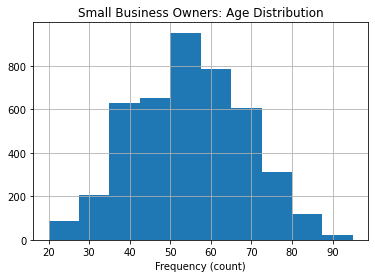

In [31]:
# Plot histogram of "AGE"
df_small_biz["AGE"].hist(bins = 10)

plt.xlabel("Age")
plt.xlabel("Frequency (count)")
plt.title("Small Business Owners: Age Distribution")

From the above histogram we can see, it is normally distributed that means small business owners are mostly middle aged (between 35-70). It seems like people starting after gaining some experience and capital from their early work life.

Now we need to remove some outliers in order to avoid problems in our calculation.

In [32]:
# Calculate trimmed variance
top_ten_trim_var = df_small_biz.apply(trimmed_var,limits=(0.1,0.1)).sort_values().tail(10)
top_ten_trim_var

EQUITY      1.177020e+11
KGBUS       1.838163e+11
FIN         3.588855e+11
KGTOTAL     5.367878e+11
ACTBUS      5.441806e+11
BUS         6.531708e+11
NHNFIN      1.109187e+12
NFIN        1.792707e+12
NETWORTH    3.726356e+12
ASSET       3.990101e+12
dtype: float64

In [33]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    title = "Small Business Owners: High Variance Features"
)


fig.show()

Let's put high variance features into a list.

In [34]:
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['BUS', 'NHNFIN', 'NFIN', 'NETWORTH', 'ASSET']

Now we will turn this list into a feature_matrix `X`.

In [35]:
X = df_small_biz[high_var_cols]
print("X shape:", X.shape)

X shape: (4364, 5)


In [36]:
cols = ['BUS', 'NHNFIN', 'NFIN', 'NETWORTH', 'ASSET']
corr = df_small_biz[cols].corr()
corr.style.background_gradient(axis=None)

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
BUS,1.000000,0.972118,0.962096,0.883497,0.884248
NHNFIN,0.972118,1.000000,0.988697,0.926836,0.926296
NFIN,0.962096,0.988697,1.000000,0.937130,0.942366
NETWORTH,0.883497,0.926836,0.937130,1.000000,0.998322
ASSET,0.884248,0.926296,0.942366,0.998322,1.000000


In [37]:
X.mean()

BUS         1.836791e+06
NHNFIN      2.360007e+06
NFIN        3.020451e+06
NETWORTH    3.980727e+06
ASSET       4.253570e+06
dtype: float64

In [38]:
X_summary = X.aggregate(["mean","std"]).astype("int")
X_summary

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
mean,1836791,2360007,3020450,3980726,4253569
std,7487801,8580907,9614610,11935031,12329117


In [39]:
# Instantiate transformer
ss = StandardScaler()

# Transform `X`
X_scaled_data = ss.fit_transform(X)

# Put `X_scaled_data` into DataFrame
X_scaled = pd.DataFrame(X_scaled_data, columns=X.columns)

#print("X_scaled shape:", X_scaled.shape)
X_scaled.head()

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
0,-0.245333,-0.248954,-0.238877,-0.313661,-0.279287
1,-0.245333,-0.249071,-0.238981,-0.313745,-0.279368
2,-0.245333,-0.248954,-0.238877,-0.313661,-0.279287
3,-0.245333,-0.249187,-0.239086,-0.313913,-0.279449
4,-0.245333,-0.249071,-0.238981,-0.313661,-0.279368


In [40]:
X_scaled_summary = X_scaled.aggregate(["mean","std"]).astype(int)
X_scaled_summary

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
mean,0,0,0,0,0
std,1,1,1,1,1


## Build Model
Now that our data is in order, let's get to work on the model.

In [41]:
# Build model
model = KMeans(n_clusters=3, random_state = 42)
# Fit model to data
model.fit(X)

KMeans(n_clusters=3, random_state=42)

In [42]:
labels = model.labels_
labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [45]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    model.fit(X)
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    # Calculate Silhouette Score
    silhouette_scores.append(
        silhouette_score(X, model.named_steps["kmeans"].labels_)
    )

print("Inertia:", inertia_errors[:11])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [5765.863949365074, 3070.4294488357573, 2220.2921850896846, 1777.4635570665591, 1443.786007103407, 1173.3701169575006, 1004.0082329287374, 892.7197264630447, 780.7646441851745, 678.9317940468635, 601.010706235275]

Silhouette Scores: [0.9542706303253067, 0.8446503900103915, 0.7422220122162623]


In [48]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters, y=inertia_errors, title="K-Means Model: Inertia vs Number of Clusters"
)
fig.show()

The trick with choosing the right number of clusters is to look for the "bend in the elbow" for this plot. In other words, we want to pick the point where the drop in inertia becomes less dramatic and the line begins to flatten out. In this case, it looks like the sweet spot is 3.

In [49]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x=n_clusters,
    y=silhouette_scores,
    title="K-Means Model: Silhouette Score vs Number of Clusters"
)

fig.show()

In contrast to our inertia plot, bigger is better. So we're not looking for a "bend in the elbow" but rather a number of clusters for which the silhouette score still remains high. We can see that silhouette score drops drastically beyond 3 clusters. Given this and what we saw in the inertia plot, it looks like the optimal number of clusters is 3.

In [52]:
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=3,random_state=42)
)
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

## Communicate the result

In [53]:
labels = final_model.named_steps["kmeans"].labels_
xgb = X.groupby(labels).mean()
xgb

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
0,7.367185e+05,1.002199e+06,1.487967e+06,2.076003e+06,2.281249e+06
1,6.874479e+07,8.202115e+07,9.169652e+07,1.134843e+08,1.167529e+08
2,1.216152e+07,1.567619e+07,1.829123e+07,2.310024e+07,2.422602e+07


In [54]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode="group",
    title="Small Business Owner Finances by Cluster"
)


fig.show()

Remember that our clusters are based partially on `NETWORTH`, which means that the households in the 0 cluster have the smallest net worth, and the households in the 1 cluster have the highest. Based on that, there are some interesting things to unpack here.

As we are looking into small businesses in this project, cluster 0 and 2 all the small business data. `BUS` value has understandably positive relationships with `NETWORTH`, `ASSET` and others. As value of the business increases, `NETWORTh` and other values will automatically increase.

In [55]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1","PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4364, 2)


,PC1,PC2
0,-6.220648e+06,-503841.638839
1,-6.222523e+06,-503941.888901
2,-6.220648e+06,-503841.638839
3,-6.224927e+06,-504491.429465
4,-6.221994e+06,-503492.598399


In [57]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame = X_pca,
    x="PC1",
    y="PC2",
    color=labels.astype(str),
    title="PCA Representation of Clusters"
)


fig.show()

One limitation of this plot is that it's hard to explain what the axes here represent. In fact, both of them are a combination of the five features we originally had in X, which means this is pretty abstract. Still, it's the best way we have to show as much information as possible as an explanatory tool for people.

So what does this graph mean? It means that we made three tightly-grouped clusters that share some key features. 